In [1]:
# import packages
import os
import six
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as clrs
import matplotlib.transforms as transforms
import numpy as np
import scanpy as sc
import glob
import anndata as an
import seaborn as sns
from tqdm.notebook import tqdm
from random import sample
from anndata import AnnData
from dask.base import get_name_from_key
from IPython.display import IFrame

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# print package versions
import session_info
session_info.show()

# Variables, Info, and Data Paths

In [4]:
# number of degrees to turn each of the regions in order to orient them in the same way, used later 
transform_degrees = {
    '1_0': 35,
    '2_0': 35 + 270,
    '2_1': 35 + 270,
    '4_0': 35 + 180,
    '4_1': 35 + 180,
    '6_0': 35 + 180,
    '6_1': 35 + 180
}
# regions refer to each individual tissue section
regions_list = ['1_0','2_0','2_1','4_0','4_1','6_0','6_1']

# gene lists 
neuron_gene_list = 'Ascl1,Nkx2-2,Foxn4,Nrxn3,Megf11,Ret,Nrxn1,Lhx2,Lhx4,Neurog3,Uncx,Hmx2,Hmx3,Bhlhe23,Lhx1,Cbln1,Lhx3,Barhl2,Tlx3,Otp,Pax8,Lbx1,Pax2,Bhlhe22,Slc10a4,Slc18a3,Evx1,Vsx2,Sox14,Vsx1,Onecut2,Pou2f2,Tubb3,Elavl3'.split(',')
mesoderm_gene_list = 'Foxc1,Foxc2,Meox1,Meox2,Myog'.split (',')
neural_crest_gene_list = 'Dlx2,Sox10'.split (',')
neural_progenitor_gene_list = 'Wnt1,Olig3,Irx3,Pax6,Dbx2,Dbx1,Sp8,Nkx6-2,Nkx6-1,Foxa2,Shh,Sox2,Pax7,Gsx1,Olig2,Pax3'.split(',')
blood_gene_list = 'Car2,Hemgn,Klf1,Sox17,Fermt3'.split(',')
DRG_gene_list = 'Krt8,Tlx2'.split(',')
NC_progenitor_gene_list = 'Mafb,Zic3'.split(',')

markers = {
    'Neuron': neuron_gene_list,
    'Neural progenitor': neural_progenitor_gene_list,
    'Mesoderm': mesoderm_gene_list,
    'DRG': DRG_gene_list,
    'Blood': blood_gene_list,
    'Neural crest': neural_crest_gene_list,
    'Pre-EMT NC progenitor': NC_progenitor_gene_list
}

# These are the markers used for ScTyping
full_marker_list = 'Klf1,Hemgn,Car2,Sox17,Fermt3,Tlx2,Krt8,Foxc1,Foxc2,Meox1,Meox2,Myog,Dlx2,Sox10,Wnt1,Olig3,Irx3,Pax6,Dbx2,Dbx1,Sp8,Nkx6-2,Nkx6-1,Foxa2,Shh,Sox2,Pax7,Gsx1,Olig2,Pax3,Ascl1,Nkx2-2,Foxn4,Nrxn3,Megf11,Ret,Nrxn1,Lhx2,Lhx4,Neurog3,Uncx,Hmx2,Hmx3,Bhlhe23,Lhx1,Cbln1,Lhx3,Barhl2,Tlx3,Otp,Pax8,Lbx1,Pax2,Bhlhe22,Slc10a4,Slc18a3,Evx1,Vsx2,Sox14,Vsx1,Onecut2,Pou2f2,Tubb3,Elavl3,Zic3,Mafb'.split(',') 

# This is the 36 genes worked with in the DNM cohort
MM_DNM_gene_list = ['Add2', 'Atg10', 'Bicra', 'Celsr1', 'Chordc1', 'Cnpy1','Ehd4','Evl','Fam83g','Gon4l','Med13l','Mink1','Mta3','Mul1','Opalin','Osbpl5','Plg', 'Pop1','Ppp1r14c','Ppp5c','Pttg1ip','Rc3h2','Rnd2','Scaper','Sec31a','Serpinb12','Slain2','Smurf2','Spen','Spx','Stab1','Tcf12','Unc80','Whamm','Xirp2','Zswim6']

# used to mark gene expression values as positive
def positive(value):
    return max(value, 0)


In [5]:
# read clustered analysis
adata = sc.read('DNM_MERFISH_M085_filtered_normalized_UMAP.h5ad')

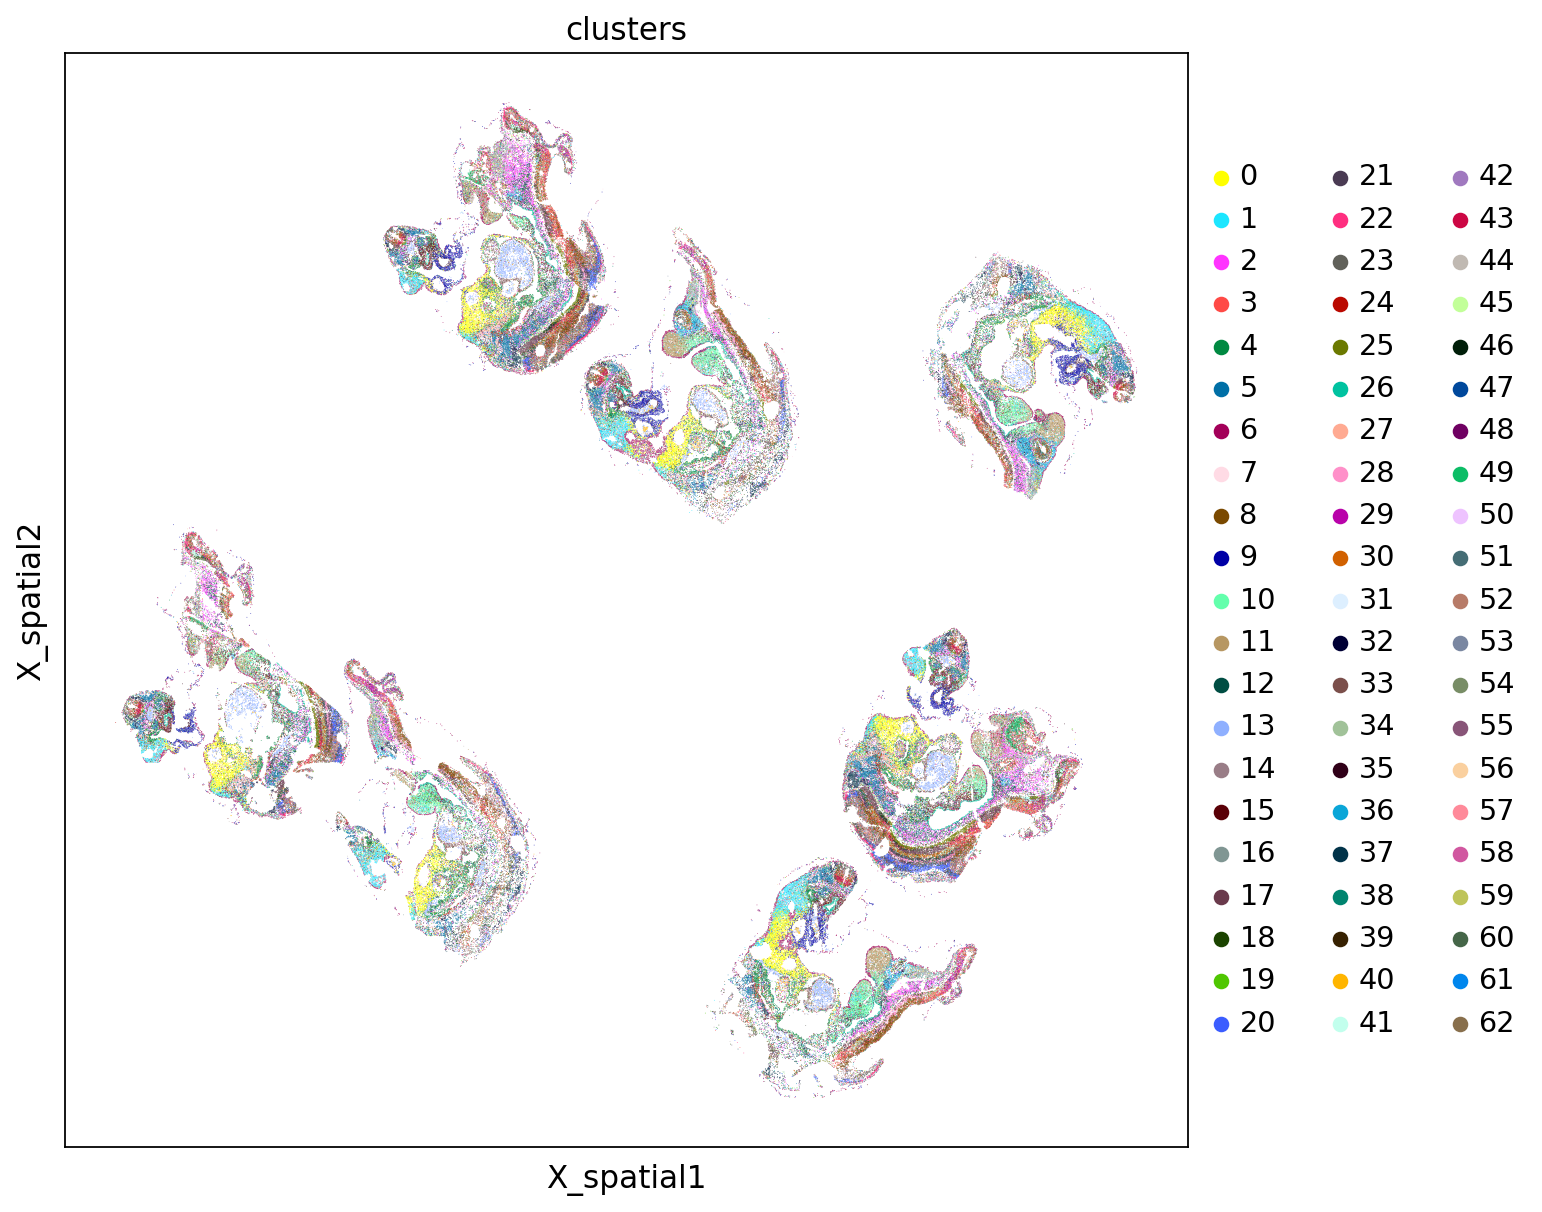

In [6]:
# plot clusters
sc.set_figure_params(figsize=(9,9),facecolor='white')
sc.pl.embedding(adata, basis='X_spatial', color="clusters")

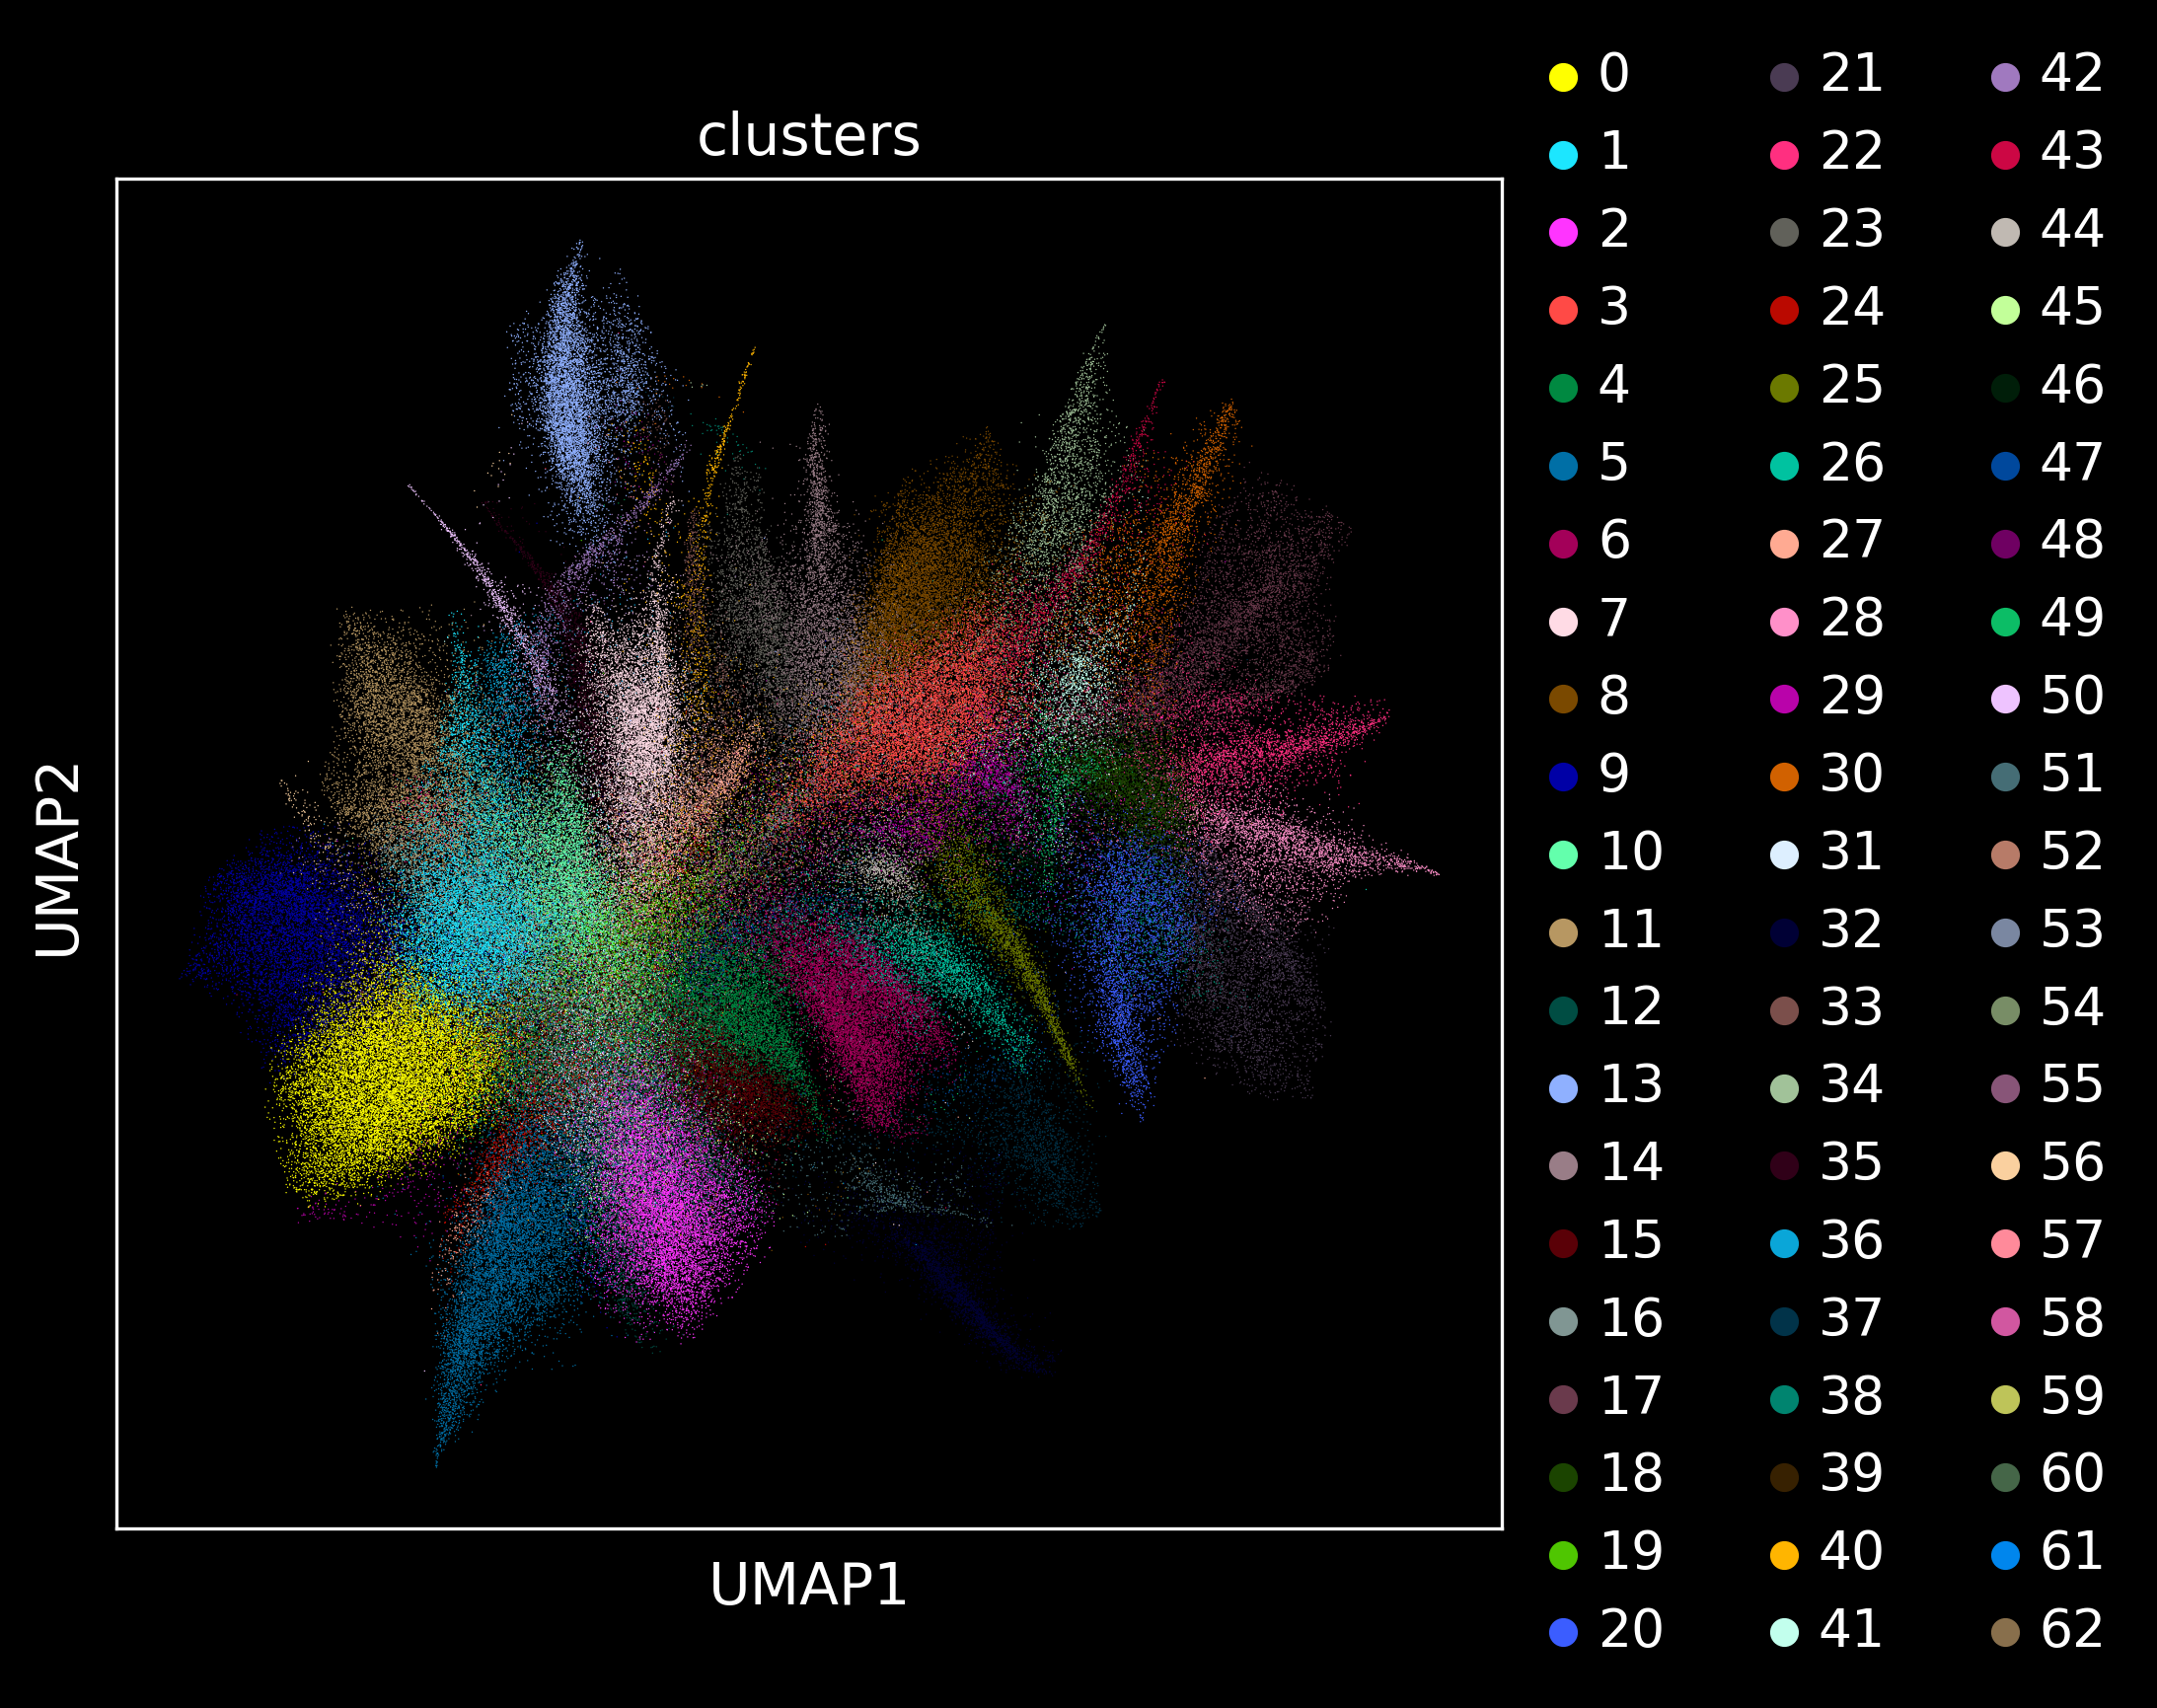

In [7]:
# plot UMAP
sc.set_figure_params(figsize=(6,6), dpi=150)
plt.style.use("dark_background")
sc.pl.umap(adata,color='clusters')

# Plotting of 36 Candidate genes at 0-2 scale

In [8]:
# PDF exceeds Github limit, will be attached for viewing
plt.style.use("dark_background")
with PdfPages('regions_colored_by_candidate_grid_0_to_2.pdf') as pdf:
    for z in range(len(MM_DNM_gene_list) // 37 + 1):
        subset_list = MM_DNM_gene_list[z*37:min((z+1)*36,len(MM_DNM_gene_list))]
        fig, axs = plt.subplots(ncols=7, nrows=len(subset_list), figsize=(14,len(subset_list)*2),dpi=500)
        plt.style.use("dark_background")
        for j in range(len(regions_list)):
            adataj = adata[adata.obs['region'] == regions_list[j]]
            for i in range(len(subset_list)):
                transform = transforms.Affine2D().rotate_deg(transform_degrees[regions_list[j]])
                trans_data = transform + axs[i,j].transData
                sc.pl.embedding(adataj, layer='volume_normalized',colorbar_loc = None, basis="X_spatial",ax=axs[i,j],vmin='0', vmax="2", color=subset_list[i], frameon=False,show=False,transform=trans_data)
                if j == 0:
                    fig.text(axs[i,j].get_position().x0-0.01,axs[i,j].get_position().y0 + axs[i,j].get_position().height/2,subset_list[i], style='italic',rotation='vertical',horizontalalignment='center',verticalalignment='center')
                if i == 0:
                    axs[i,j].set_title('region ' + regions_list[j])
                else:
                    axs[i,j].set_title('')
        pdf.savefig(fig, bbox_inches = "tight",dpi=500)
        plt.close(fig)

# Individual plots for Marker Gene Scores

In [6]:
# PDF exceeds Github limit, will be attached for viewing
for i in markers.keys():
    genes = markers[i]
    sc.tl.score_genes(adata,gene_list = genes, score_name='gene_group_' + i)
plt.style.use("dark_background")
regions_list = ['1_0','2_0','2_1','4_0','4_1','6_1','6_0']
cell_types_list = ['Neuron','Neural progenitor', 'Mesoderm', 'DRG', 'Blood', 'Neural crest', 'Pre-EMT NC progenitor']
with PdfPages('regions_colored_by_marker_group_grid_overlapped.pdf') as pdf:
    fig, axs = plt.subplots(ncols=7, nrows=7, figsize=(14,14),dpi=500)
    for j in range(len(regions_list)):
        adataj = adata[adata.obs['region'] == regions_list[j]]
        for i in range(len(cell_types_list)):
            transform = transforms.Affine2D().rotate_deg(transform_degrees[regions_list[j]])
            trans_data = transform + axs[j,i].transData
            sc.pl.embedding(adataj, colorbar_loc = None, basis="X_spatial",ax=axs[j,i],vmin='0', vmax="0.0005", color='gene_group_' + cell_types_list[i], frameon=False,show=False,transform=trans_data)
            if i == 0:
                fig.text(axs[j,i].get_position().x0-0.01,axs[j,i].get_position().y0 + axs[j,i].get_position().height/2,'region ' + regions_list[j],rotation='vertical',horizontalalignment='center',verticalalignment='center')
            if j == 0:
                axs[j,i].set_title(cell_types_list[i])
            else:
                axs[j,i].set_title('')
    axs[0,6].set_title('NC progenitor')
    pdf.savefig(fig, bbox_inches = "tight",dpi=500)
    plt.close()